In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.special import inv_boxcox
from scipy.stats import boxcox

tf.config.run_functions_eagerly(True)

In [ ]:
# Read in buoy data
buoy=pd.read_csv('data/buoy41002.csv')
buoy['time']=pd.to_datetime(buoy['time'])

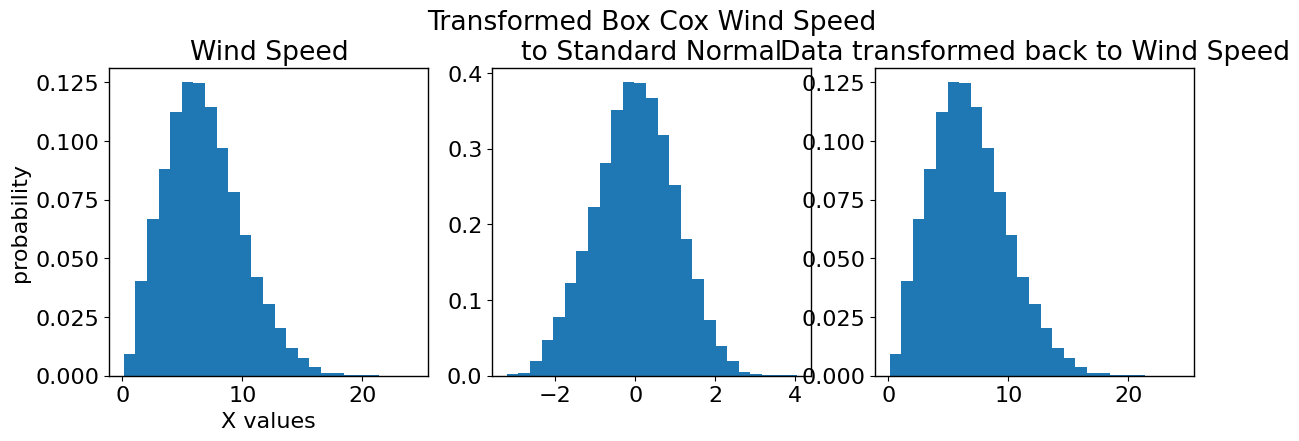

In [ ]:
# Plot distributions of buoy data

# Histogram of buoy data
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14, 4))
axs[0].set_title('Wind Speed')
axs[0].hist(buoy['w'], bins=25, density=True)
axs[0].set_xlabel('X values')
axs[0].set_ylabel('probability')

# Histogram of buoy data after transformed to standard normal distribution
xt, lmbda = boxcox(buoy['w'])
mn,std=xt.mean(),xt.std()
xt=(xt-mn)/std
axs[1].hist(xt,bins=25,density=True)
axs[1].set_title('Transformed Box Cox Wind Speed\nto Standard Normal')

# Histogram of standard normal distribution transformed back to wind speed
xt=xt*std+mn
xt_t=inv_boxcox(xt,lmbda)
axs[2].hist(xt_t,bins=25,density=True)
axs[2].set_title('Data transformed back to Wind Speed')
plt.show()

In [ ]:
# Read in NBS
nbs=xr.open_dataset('data/nbs_train.nc')

# Window size is 2n+1
n=10

center=[360-75,31.75]
lats=np.arange(center[1]-n*.25,center[1]+(n+1)*.25,.25)
lons=np.arange(center[0]-n*.25,center[0]+(n+1)*.25,.25)
# Get locations within image
lat_bounds=[min(lats),max(lats)]
lon_bounds=[min(lons),max(lons)]

# Select only data near buoy
nbs=nbs.sel(lat=slice(min(lats),max(lats)),lon=slice(min(lons),max(lons)))

In [ ]:
# Split the buoy data into train/val/test
Y_train=buoy.loc[buoy['fold']<=3]
Y_val=buoy.loc[buoy['fold']==4]
Y_test=buoy.loc[buoy['fold']==5]
Y_train

# Get the times for each dataset
train_times=Y_train['time']
val_times=Y_val['time']
test_times=Y_test['time']

# Split NBS into train/val/test
X_train=nbs.sel(time=nbs['time'].isin(Y_train['time']))
X_val=nbs.sel(time=nbs['time'].isin(Y_val['time']))
X_test=nbs.sel(time=nbs['time'].isin(Y_test['time']))

In [ ]:
Y_train=np.array(Y_train['w'])
Y_val=np.array(Y_val['w'])
Y_test=np.array(Y_test['w'])

X_train=np.array(X_train['w'])
X_val=np.array(X_val['w'])
X_test=np.array(X_test['w'])

In [ ]:
Y_test.min(),Y_test.max(),Y_train.min(),Y_train.max()

(0.5567567567567568, 19.41081081081081, 0.2, 24.27916666666667)

In [ ]:
X_test.max(),X_train.max(),X_val.max()

(49.72066, 50.558, 70.0)

In [ ]:
# Standardize the buoy data

# First apply box cox to train data to get normal distribution
Y_train, lmbda_y = boxcox(Y_train)
# Get mean and stdev and convert to standard normal
mean_y,std_y=Y_train.mean(),Y_train.std()
Y_train=(Y_train-mean_y)/std_y

# Use boxcox with known lambda on other variables
Y_val = scipy.special.boxcox(Y_val, lmbda_y)
Y_val = (Y_val-mean_y)/std_y
Y_test = scipy.special.boxcox(Y_test,lmbda_y)
Y_test = (Y_test-mean_y)/std_y

# To convert back later
# xt=xt*std+mn
# xt_t=inv_boxcox(xt,lmbda)

In [ ]:
#X_train2[X_train2==0]=0.001
#X_train2=X_train.flatten()
#X_train2, lmbda_x = boxcox(X_train2)
#X_train2=X_train2.reshape(19016,1,21,21)
#X_train2

In [ ]:
# Standardize NBS data

x_train_shape=X_train.shape
x_val_shape=X_val.shape
x_test_shape=X_test.shape

# Make all values positive and flatten to 1D
X_train[X_train==0]=0.001
X_train=X_train.flatten()
# Apply box cox to train data to get normal distribution
X_train, lmbda_x = boxcox(X_train)
X_train=X_train.reshape(x_train_shape)

#X_train, lmbda_x = boxcox(X_train)
# Get mean and stdev and convert to standard normal
#X_train=np.log(X_train)
mean_x,std_x=X_train.mean(),X_train.std()
X_train=(X_train-mean_x)/std_x

# Use boxcox with known lambda on other variables
X_val[X_val==0]=0.001
X_val = scipy.special.boxcox(X_val, lmbda_x)
X_val = (X_val-mean_x)/std_x
X_test[X_test==0]=0.001
X_test = scipy.special.boxcox(X_test,lmbda_x)
X_test = (X_test-mean_x)/std_x

# To convert back later
# xt=xt*std+mn
# xt_t=inv_boxcox(xt,lmbda)

In [ ]:
Y_train.min(),Y_train.max(),Y_val.max(),Y_test.max()

(-3.1298556098974766,
 3.9240273631192215,
 3.3478156764125195,
 3.036666641319582)

In [ ]:
X_train.min(),X_train.max(),X_val.max(),X_test.max()

(-4.367063, 8.467445, 11.024377, 8.348296)

In [ ]:
# Remove the zlev dimension
X_train=X_train.squeeze()
X_val=X_val.squeeze()
X_test=X_test.squeeze()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(21, 21, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='linear'))

In [ ]:
#model.summary()

In [ ]:
model.compile(loss = "MeanSquaredError", metrics='mse',
              optimizer=keras.optimizers.Adam(learning_rate = 1e-5))

In [ ]:
epochs=10
batch_size=128

In [ ]:
history=model.fit(X_train,Y_train,epochs=epochs,
                  batch_size=batch_size, validation_data=(X_val,Y_val))

Epoch 1/10
149/149 [==============================] - 7s 47ms/step - loss: 0.8783 - mse: 0.8783 - val_loss: 0.6794 - val_mse: 0.6794
Epoch 2/10
149/149 [==============================] - 6s 40ms/step - loss: 0.7463 - mse: 0.7463 - val_loss: 0.5448 - val_mse: 0.5448
Epoch 3/10
149/149 [==============================] - 7s 47ms/step - loss: 0.6404 - mse: 0.6404 - val_loss: 0.4636 - val_mse: 0.4636
Epoch 4/10
149/149 [==============================] - 6s 43ms/step - loss: 0.5665 - mse: 0.5665 - val_loss: 0.4172 - val_mse: 0.4172
Epoch 5/10
149/149 [==============================] - 6s 43ms/step - loss: 0.5200 - mse: 0.5200 - val_loss: 0.4008 - val_mse: 0.4008
Epoch 6/10
149/149 [==============================] - 7s 45ms/step - loss: 0.4965 - mse: 0.4965 - val_loss: 0.3924 - val_mse: 0.3924
Epoch 7/10
149/149 [==============================] - 6s 41ms/step - loss: 0.4855 - mse: 0.4855 - val_loss: 0.3910 - val_mse: 0.3910
Epoch 8/10
149/149 [==============================] - 7s 48ms/step - 

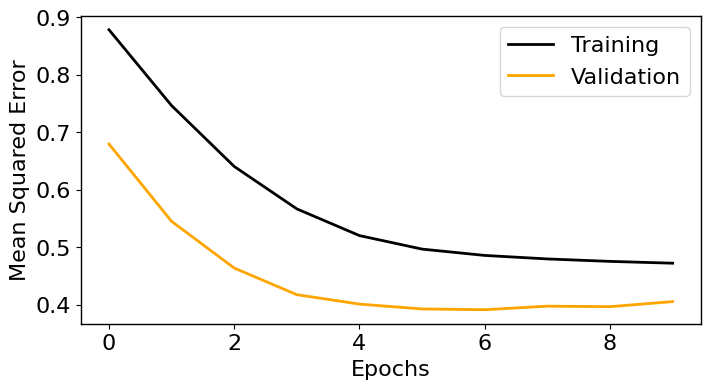

In [ ]:
# Plot training graph

fig = plt.figure(figsize=(8, 4))
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.plot(history.history['mse'], label='Training', color='black', linewidth=2)
plt.plot(history.history['val_mse'], label = 'Validation', color='orange', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

In [ ]:
X_test.max()

8.348296

In [ ]:
pred = model.predict(X_test)

52/52 [==============================] - 0s 8ms/step


In [ ]:
pd.DataFrame(pred).describe()

,0
count,1635.000000
mean,0.060466
std,0.687202
min,-1.901745
25%,-0.423006
50%,0.136416
75%,0.542991
max,2.524747


In [ ]:
#pred=pred/
pred=pred*std_y+mean_y
pred=inv_boxcox(pred,lmbda_y)
true=Y_test*std_y+mean_y
true=inv_boxcox(true,lmbda_y)

In [ ]:
pred=pred.squeeze()

In [ ]:
diffs=pred-true
pd.DataFrame(diffs).describe()

,0
count,1635.000000
mean,0.035502
std,1.903507
min,-8.089557
25%,-1.044303
50%,0.084353
75%,1.197203
max,7.286140


In [ ]:
diffs=abs(pred-true)
pd.DataFrame(diffs).describe()

,0
count,1635.000000
mean,1.445322
std,1.238696
min,0.000443
25%,0.540349
50%,1.129960
75%,2.012691
max,8.089557


In [ ]:
(np.mean((pred-true)**2))**0.5

1.9032559747436044

In [ ]:
results=pd.DataFrame({'time':test_times,'pred':pred,'true':true})
results

,time,pred,true
23757,2017-01-16 00:00:00,4.361554,4.300000
23758,2017-01-16 06:00:00,3.941863,3.745714
23759,2017-01-16 12:00:00,4.074154,1.562162
23760,2017-01-16 18:00:00,4.928396,3.080000
23761,2017-01-17 00:00:00,4.182579,3.994595
...,...,...,...
25387,2018-02-28 06:00:00,7.733763,7.011429
25388,2018-02-28 12:00:00,6.931675,6.145946
25389,2018-02-28 18:00:00,7.201329,5.382857
25390,2018-03-01 00:00:00,7.351584,5.162162


Text(0.5, 1.0, 'CNN Output for Test Data')

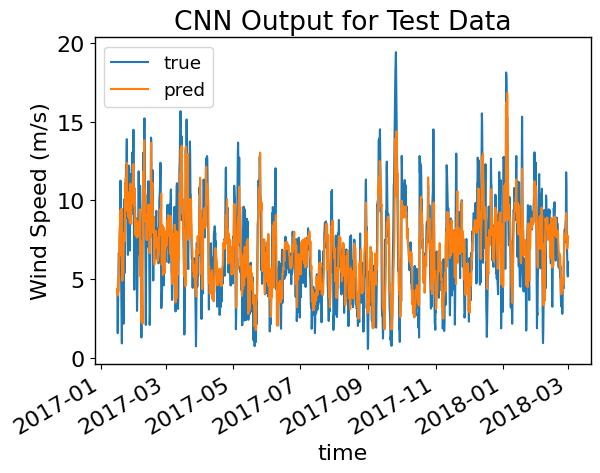

In [ ]:
results.plot(x='time',y=['true','pred'])
plt.legend(fontsize='small')
plt.ylabel('Wind Speed (m/s)')
plt.title('CNN Output for Test Data')